In [1]:
using Pkg
using Revise

In [2]:
Pkg.activate("/home/gribeill/GitHub/HiQuER/")

  Activating project at `~/GitHub/HiQuER`


In [3]:
using HiQuER
using QuantumClifford

┌ Info: Precompiling HiQuER [4b5eb2ad-d69c-411d-be4a-18f852c96210]
└ @ Base loading.jl:1423


## Angles

Angles are represented by types that subtype the `AbstractAngle` abstract type. Two are provided:

- `Angle`, which stores the angle as a rational multiple of $\pi$
- `FloatAngle`, which stores the angle as a floating point multiplier of $\pi$

In [4]:
Angle(3//2) - Angle(3//8), FloatAngle(0.34) + FloatAngle(0.11), 2*FloatAngle(1//4)

(9π/8, 0.45π, 0.5π)

In [5]:
Angle(1//2) ≈ FloatAngle(0.5)

true

## Gates

Gates subtype the `AbstractGate` abstract type. Built-in types include:

- `Gate`, which is a symbolic gate with no concrete implementation (but that can have standard operations such as adjoint applied to it.

- `PauliGate`, which associates a Pauli operator {$\sigma_x$, $\sigma_y$, $\sigma_z$} with an `Angle` value to represent single-qubit rotations around an axis of the Bloch sphere.

- `ControlledGate`, which associates one or more Pauli operators as control operators and one Pauli as the target operator. For example, the standard CNOT gate is associated with $\sigma_z$ as the control Pauli and $\sigma_x$ as the target Pauli.

- `Measure`, which indicates a measurement in the basis of a given Pauli operator

<font color='red'>TODOs:</font>

- Check that the above Pauli operators are single-qubit operators for single-qubit gates, and collapse the vector of Pauli operator for the ControlledGate control into a single multi-qubit Pauli

- How do we represent these as unitary matrices? Don't want to carry around a potentially large matrix -- need a conversion function to a UnitaryGate type??


In [6]:
#The Hadamard gate is self-adjoint
H' == H

true

In [7]:
#Built in useful gates, with the last one being a π/2 rotation around the X axis
T, S', X180

(T, S†, X)

In [8]:
#Another way to define a rotation gate
PauliGate(Y, Angle(3//4))

Ry(3π/4)

In [9]:
CNOT.ctrl_pauli, CNOT.tgt_pauli

(PauliOperator[+ Z], + X)

## Circuits

The model for circuits is similar to that used in Cirq: a `Circuit` object is an ordered list of `Slices`, each of which represent an operation on a disjoint set of qubits acting at a particular time during the circuit. Each slice maps a `Gate` object to one or more qubits, which are represented by integer id's. 

The array `[.]` operator is used as a shorthand to represent a gate acting on a specific qubit; for example:

`H[1]` represents a Hadamard gate acting on qubit 1

<font color='red'>TODOs:</font>

- Probably many corner cases I haven't thought of

- Finish tikz-based pretty-printing of circuit

In [10]:
H[1]

(1) => H

Slices can be built up using the multiplication operator, which represents simultaneous application

In [11]:
H[1]*CNOT[2,3]

H(1)*CNOT(2, 3)

The code will not allow you to create a slice that acts multiple gates on the same qubit:

In [12]:
H[1]*S[1]

LoadError: ArgumentError: Cannot add to this slice!

There are multiple ways to build up a circuit: by `push!`-ing slices or gates:

In [13]:
c = Circuit()
push!(c, H[1])
push!(c, S[2]*T[3])
c

1: H(1)
2: T(3)*S(2)

`push!` accepts different insertion strategies based on the `when` keyword:

- `:earliest` (the default) will insert a gate into the first slice that is availble for that qubit

- `:last` will create a new slice and add the gate at the end of the circuit

In [14]:
c = Circuit([H[1], CNOT[1,3]])
push!(c, S, HiQuER.QubitId(2), when=:earliest)
c

1: S(2)*H(1)
2: CNOT(1, 3)

In [15]:
c = Circuit([H[1], CNOT[1,3]])
push!(c, S, HiQuER.QubitId(2), when=:last)
c

1: H(1)
2: CNOT(1, 3)
3: S(2)

Or from an array of slices:

In [16]:
c = Circuit([S[1], CNOT[1,2], H[2]])

1: S(1)
2: CNOT(1, 2)
3: H(2)

The adjoint of a circuit will be automatically constructed in the expected way:

## QASM interop

Circuits can be converted into OpenQASM 2.0 files with the `to_qasm` function.

<font color='red'>TODOs:</font> 

- Finish QASM -> Circuit converter. Can succesfully parse file into a `QASMListing` object but need to finish the conversion to a `Circuit`


In [17]:
to_qasm(c)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
s q[0];
cx q[0], q[1];
h q[1];

To define an OpenQASM gate not in the standard "qelib1.inc" header file, the function can be passed additional `QASMGateDef` objects created from circuits:

In [18]:
qdef = QASMGateDef(Circuit([Rz(Angle(1//2))[1]*Rx(Angle(3//4))[2]]), :blub)
Blub = Gate(:blub)

circ = Circuit([Blub[1]*H[2], CNOT[1,2], Blub[2]])
to_qasm(circ, gatedefs=[qdef])

OPENQASM 2.0;
include "qelib1.inc";
gate blub q1 q2 {
rx(3π/4) q2;
rz(π/2) q1;
}
qreg q[2];
h q[1];
blub q[0];
cx q[0], q[1];
blub q[1];

## Pretty pictures

You can use the nice [Quantikz.jl](https://krastanov.github.io/Quantikz/stable/) package to make nice Tikz circuit diagrams with the `draw` function. 

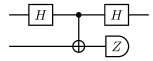

In [19]:
c = Circuit([H[1], CNOT[1,2], H[1], MEAS[2]])
draw(c)